# COGS 108 - Final Project 

# Overview

*This project is intended to find if there are underlying factors that affect a restuarant's health inspection score such as income or race. I wanted to see if minorities received lower/higher scores than white people, and if income had affected this. In my models and evaluation, I separated graphs from Race v Score and Race v Income to see if there were initial differences. Then, explored if there was any linear relationship between any of these factors.*

# Name & PID

- Name: Candy Yu
- PID: A15554746

# Research Question

*Do restaurants located in majority non-white zipcodes (>50%) have a higher or lower score? What about majority white zipcodes (<50%)? Does income explain why there is/isn't a difference in health inspection scores? If there is a difference in income, is it because of zipcodes?*

## Background and Prior Work

In my first reference, I have included research about low income vs high income restaurants and if there is a correlation between review ratings. In the conclusion, the researcher states that there is no correlation, as restaurants in high income neighborhoods also have low ratings, and vice versa. But, this does not address the racial differences that I am trying to address in this research. I will expand if there actually is no correlation between income levels and restaurant inspection scores AND racial disparities. This result will be different due to different datasets and variables. I will use this project's model evaluation, to determine if there is correlation.

In my second reference, I have included information about how segregation effects have lasted to today and affects minorities that leads to low income. The writer stated that "a color line would divide the types of housing" and "has kept [Black communities] out of the best-funded schools and highest-paying jobs". This also can connect to restaurants, as restaurants hold jobs for  minorities to work in as well, and if restaurants are also separated by neighborhood, restaurants are also low income. The "color line" divides white and non whites. The low income and segregated real estate can explain why white people can possibly have a higher up in restaurant wealth and cleanliness because businesses build in places with higher real estate, which can ultimately lead to higher health inspection ratings due to being able to afford the tools to keep up a better score. People living in lower income neighborhoods are unable to bring up their income because all the companies that provide an income that is higher are in the richer (whiter) neighborhoods.

In my third reference, I used the grading system for health inspections that is used in North Carolina because we are dealing with zipcodes from North Carolina. Under the "Counting to 100" header, it states that a score of 90-100 is an A, a score of 80-89 is a B, and a score of 70-79 is a C. This will be used in converting numeric scores to categorical letter scores. 

References (include links):
- 1) https://medium.com/swlh/is-there-a-correlation-between-a-restaurants-ratings-and-the-income-levels-of-a-neighborhood-5fe41165e4f1
    
    github link --> https://github.com/jm21/coursera-ibm-data-science-certificate-capston
    
    
- 2) https://www.dissentmagazine.org/article/how-real-estate-segregated-america-fair-housing-act-race

- 3) https://www.courier-tribune.com/article/20140830/news/308309822

# Hypothesis


*I believe that in white dominated zipcodes (>50%), the health violations, especially critical violations, would be low due to their economic stability not only in their restaurant, but also in their real estate, where suburbs are inherently racist, which is why white dominated zipcodes have higher income (see background).*

*I believe that in majority non white zipcodes (<50%), the health violations will be higher, in critical and noncritical violations, due to economic instability because certain real estates excludes minorities (see background), meaning they usually have lower income.*

# Dataset(s)

- Dataset Name: zipcodes.csv
- Link to the dataset: N/A
- Number of observations: 37

This dataset involves zipcodes and median income per family, household, and per capita. It also shows families/people who receive benefits like snap, or SSI, and people who are below the poverty line. It also shows the percentage of nonwhite people are in those zipcodes


- Dataset Name: inspections.csv
- Link to the dataset: N/A
- Number of observations: 18466

This dataset shows the specific restaurant and location. It also shows any non critical and critical citations it received, including the score


I plan to combine the zipcodes with the inspection with specific columns. I will match the zipcodes to the restaurants in those zipcodes, and compare the number of citations (non/critical) in those zipcodes. By using the zipcodes "percent_nonwhite" and the income columns, I will be able to associate restaurants in those zipcodes.


# Setup

In [92]:
%matplotlib inline

# Import libraries
import numpy as np
import pandas as pd
import seaborn as sns

import matplotlib.pyplot as plt
from scipy import stats

import patsy
import statsmodels.api as sm

from sklearn import linear_model
from sklearn.metrics import r2_score


In [93]:
inspections = pd.read_csv('inspections.csv')

In [94]:
zipcodes = pd.read_csv('zipcodes.csv')

# Data Cleaning

First, I merged the zipcodes dataframe to the inspections dataframe to read all data together instead of separately. I saved this to df_combined

In [95]:
## YOUR CODE HERE
## FEEL FREE TO ADD MULTIPLE CELLS PER SECTION
df_combined = inspections.merge(zipcodes, how = 'left')


I then dropped all irrelevant columns from my df_combined. I saved this to df_clean

In [96]:
df_clean = (df_combined.drop(['critical','description','city','state','hsisid', 'date','facilitytype',
                             'percent_supplemental_security_income','percent_snap_benefits',
                             'percent_damilies_below_poverty_line','num_critical_previous',
                              'num_non_critical_previous','num_critical_mean_previous','num_non_critical_mean_previous',
                              'median_household_income_dollars','per_capita_income_dollars',
                             'phonenumber','postalcode','address1','x','y',
                            'restaurantopendate','avg_neighbor_num_critical','avg_neighbor_num_non_critical',
                            'top_match','second_match', 'previous_inspection_date',
                            'days_since_previous_inspection','previous_inspection_by_same_inspector',
                            'inspectedby','days_from_open_date','inspector_id','address2',
                            'geocodestatus','type'], axis = 1))


I also wanted to drop zipcodes that I did not have data about. Because this dataframe is so large, I think that letting go of this data is reasonable

In [97]:
df_clean = df_clean.dropna()

I renamed a super long column to make it into a shortcut

In [98]:
df_clean = df_clean.rename(columns = {'median_family_income_dollars' : 'median_fam_income', 
                                      'num_critical' : 'critical' ,
                                     'num_non_critical' : 'noncritical'})

I then reset the index of my dataframe for numbers to be in order

In [99]:
df_clean = df_clean.reset_index()

In [100]:
df_clean['percent_nonwhite'].unique()

array([72.7, 27.8, 26.3, 18. , 31.8, 33.9, 24.8, 52.6, 25. , 41.3, 35.2,
       14.8, 19.6, 27.2, 23.2, 18.9, 22.6, 30.4, 53.3, 69.9, 44.4, 22.5,
       19.7,  8.7, 19.9, 19. , 25.6, 16.6, 22.4, 32.8, 17.4, 13.6, 23.5,
       14.6, 17.9, 31.4])

Making the percentages easier to read and categorizing them by writing a function.

In [101]:
def convert_per(per):
    if per > 50.0:
        return 'Minority Area'
    elif per < 50.0:
        return 'White Area'
    else:
        return per

Make scores easier to categorize by writing a function to apply each score to a letter. 

In [102]:
def convert_score(score):
    if score >= 90.0:
        return 'A'
    elif score >= 80.0:
        return 'B'
    elif score >= 70.0:
        return 'C'

Apply the function convert_per to the column 'percent_nonwhite' and create a new column so that percentages are not erased and creates a category with the new column instead.


In [103]:
#df_clean['percent_nonwhite']= 
df_clean['percent_nonwhite'] = pd.to_numeric(df_clean['percent_nonwhite'])
df_clean = (df_clean.assign(race = df_clean['percent_nonwhite'].apply(convert_per)))


Apply the function convert_score to the column 'score' and create a new column 'letter' with the conversions

In [104]:
df_clean = (df_clean.assign(letter = df_clean['score'].apply(convert_score)))

In [105]:
df_clean

,index,name,zip,inspection_num,score,critical,noncritical,median_fam_income,percent_nonwhite,race,letter
0,0,Cafe 3000 At Wake Med,27610,1,96.0,9,7,49213.0,72.7,Minority Area,A
1,1,Overtime Sports Pub,27610,1,98.0,0,11,49213.0,72.7,Minority Area,A
2,2,TASTE OF CHINA,27610,1,97.0,4,8,49213.0,72.7,Minority Area,A
3,3,Panera Bread #1643,27513,1,99.0,2,3,109736.0,27.8,White Area,A
4,4,WalMart Supercenter #4499-00 Deli/Bakery,27597,1,97.0,2,4,59395.0,26.3,White Area,A
...,...,...,...,...,...,...,...,...,...,...,...
18226,18461,Sino Wok,27616,10,93.0,6,13,60033.0,52.6,Minority Area,A
18227,18462,Weatherstone Elem. Sch. Cafeteria,27513,9,97.0,2,3,109736.0,27.8,White Area,A
18228,18463,ALSTON RIDGE ELEMENTARY SCHOOL CAFETERIA,27519,9,96.0,3,4,137193.0,35.2,White Area,A
18229,18464,Food Lion #996 Meat Market,27603,10,99.0,1,2,68608.0,25.6,White Area,A


# Data Analysis & Results

## Models

In Figure 1 and Figure 2, I used boxplots to illustrate one categorical variable of minority vs white areas using the quantitative variables (income, score). Using the boxplots, it showed me outliers, the range, and median, which is useful to see. 

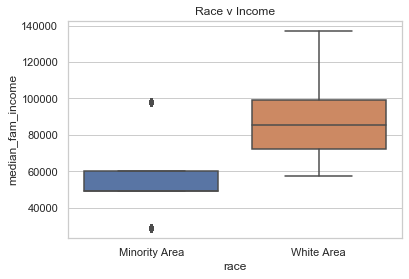

In [107]:
#Figure 1
sns.set(style = 'whitegrid')
ax = sns.boxplot(x = 'race', y = 'median_fam_income', data = df_clean).set_title('Race v Income')


The boxplot above shows that in majority white zipcodes, white people make more than minorities. There are a few minority outliers though (some more, some less income). This aligns with my hypothesis that white people have a higher income than minorities, hence why they can afford tools to better their restaurant to apply to health inspection tests. But is this the correlation?

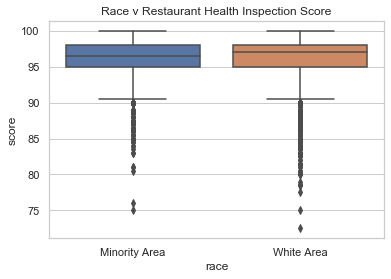

In [108]:
#Figure 2
sns.set(style = 'whitegrid')
ax2 = sns.boxplot(x = 'race', y = 'score', data = df_clean).set_title('Race v Restaurant Health Inspection Score')


In the boxplot above, it seems that there is a small difference in median of score, with white people usually having a higher score than minorities. Still, is this due to income?

In Figure 3, I used a barplot to compare race to income, and seeing where Restaurant letter scores stand. The grouped barplot was used to show two categorical variables (letter grade and race) and find its relationship (if any)

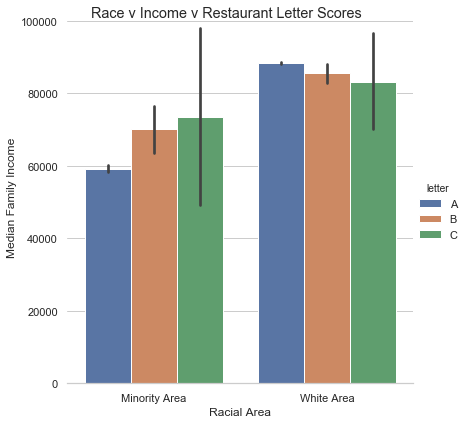

In [109]:
#Figure 3
race_income = sns.catplot(x='race', y = 'median_fam_income', 
                          hue = 'letter',
                          data=df_clean,
                          height=6, kind = 'bar')
race_income.despine(left=True)
race_income.set_ylabels('Median Family Income')
race_income.set_xlabels('Racial Area')
race_income.fig.suptitle('Race v Income v Restaurant Letter Scores')
Figure3 = plt.gcf()


The graph above shows that there's an inverse relationship between income and letter grade between minorities and white areas. In the minority area, it shows that the median income is lower with an A letter grade, and increases, with the C letter grade having the highest income of the three in minority areas.

In white areas, it has the opposite affect, where the letter A grade has the highest median income, and the letter C grade has the lowest median income. 

In general, the minority areas have the lower median family income. 

But does it affect the number of ratings?

In the following figure 4 and 5, I wanted to see if there was a linear relationship.

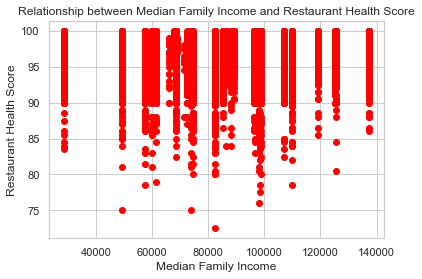

In [110]:
#Figure 4
plt.scatter(df_clean['median_fam_income'],df_clean['score'], color = 'red')
plt.xlabel('Median Family Income')
plt.ylabel('Restaurant Health Score')
plt.title('Relationship between Median Family Income and Restaurant Health Score')
plt.show()


The model above shows that there is no linear relationship between restaurant scores and median family income. What about percent of nonwhite people?

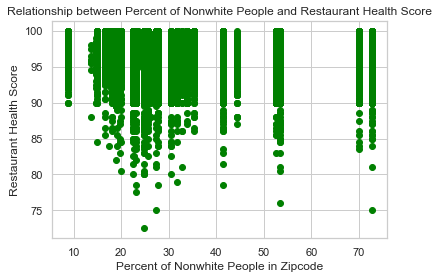

In [111]:
#Figure 5
plt.scatter(df_clean['percent_nonwhite'],df_clean['score'], color = 'green')
plt.xlabel('Percent of Nonwhite People in Zipcode')
plt.ylabel('Restaurant Health Score')
plt.title('Relationship between Percent of Nonwhite People and Restaurant Health Score')
plt.show()

Also, no linear relationship between nonwhite people and restaurant score.

In [112]:
#modelling data of median family income, percent nonwhite, and score
regression1 = linear_model.LinearRegression()
x = np.asanyarray(df_clean[['median_fam_income','percent_nonwhite']])
y = np.asanyarray(df_clean[['score']])
regression1.fit (x, y)
# The coefficients
print ('Coefficients: ', regression1.coef_)
print ('Intercept: ',regression1.intercept_)

Coefficients:  [[ 2.25327489e-06 -3.05591189e-03]]
Intercept:  [96.13048764]


The above is an extraction from my second reference link.

## Model Evaluation

This should prove that there is no linear relationship between race and income and score. 

The following model evaluation is extracted from my second reference link.

In [113]:
#finding the R square
predict_y= regression1.predict(x)
print('Variance score: %.2f' % regression1.score(x, y))
print('Mean absolute error: %.2f' % np.mean(np.absolute(predict_y - y)))
print('Residual sum of squares (MSE): %.2f' % np.mean((predict_y - y) ** 2))
print('R2-score: %.2f' % r2_score(predict_y , y) )


Variance score: 0.00
Mean absolute error: 2.03
Residual sum of squares (MSE): 7.06
R2-score: -842.87


Because the R square is very negative, there is no relationship between the median income, percent nonwhite, and score. 

# Ethics & Privacy

## Ethics

My project is intended to seek out any differences that may be caused by income discrepancies. These income differences can be due to racial differences because of racial steering in real estate from the 1960s. My research question may be coming from my own bias as an Asian woman, and I already have a view of racial minorities getting the lower end of the real estate stick. 

Another ethics problem that can arise is the fact that "minorities" are grouped together, and it's seen more of a every other race vs white people data. I think it would be better if there was separate data about Black, Hispanic, or Asian races as well. It would not group everyone together and make it a generally more specific data set. 

The representations of Black families' income can't represent Asian or Hispanic families' income, which is why it would be better to have that data, rather than grouping them together as 'nonwhite' or 'minority'.

## Privacy

The data set I used was provided for me. I'm not sure if it is public data. 

One privacy problem that I think may be a problem is the names of the restaurants. I made sure to drop the columns that included the addresses and phone numbers. I did not think dropping the names of the restaurants would be good for my research because there had to be a way to show that each restaurant had individuality and was not just grouped together through zipcode. 

The dataset I used was not based on individual people, so the Safe Harbor Method was not applicable in this situation.

## Handling Issues

In terms of handling the ethics issue, I believe that collecting data with racial demographics would be more helpful if it were collected with Asian/Black/Hispanic/White/Other in mind. If collected at just White/Other, it cuts out the representation of other races separately, and rather groups them together, which can lead to outliers.

In terms of handling privacy, I think knowing the population of a certain zipcode would be helpful not only in keeping those restaurants more private, but also to keep the owners' information private. If a zipcode had a hypothetical population of 100, the restaurant would easily be found, and known about their potential income, which may violate one's privacy.

# Conclusion & Discussion

For my research question, I wondered if there was a difference in scoring when it came to majority non white vs white zipcodes, and if the difference was due to income. In my hypothesis, I believed that majority white areas will have better restaurant scores based on their higher income, and their higher income could've been due to their zipcodes from real estate's racial divide.

I used data showing the scores that restaurants received and their zipcodes. I used another dataframe that included zipcodes, median family income, and percent of nonwhite people in that zipcode. This was useful for me to merge the two dataframes by zipcode to see which restaurants had which demographics.

Following my model evalution, there seems to be no correlation between income, race, and restaurant health inspection scores. 

In my beginning models (Figures 1-3), it looked as though there were some sort of correlation, but after evaluating my models and looking for a linear relationship, it truly showed that there was no correlation whatsoever.

A limitation in my project was not receiving any information about the population. As mentioned, it would've been helpful to have data about population in order to see if the ratio or if population could have affected the restaurant and score too. If there were more information about different cities, it could also change the data and results as there are other aspects, such as population that come into play.

The impact of my project on society is that it shows while minorities and white people have difference in income, they are all given an equal outlook on their health inspection scores. It would be interesting to see if the restaurant type is something that also affects a restaurant's health inspection score. With people going out to eat at different restaurants, it is important to show that there are differences when it comes to health inspection scores. 